<a href="https://colab.research.google.com/github/srita2003/Intel-Unnati-Industrial-Training-2025_AI-Powered-Image-Similarity-Search-and-Recommendation-System/blob/main/Fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
import random
import glob
from tensorflow.keras import applications, layers, models

if not os.path.exists('clothing-dataset-small'):
    !git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

# 2. Setup Paths
BASE_DIR = 'clothing-dataset-small/train'
IMG_SIZE = 128
BATCH_SIZE = 32


classes = [d for d in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, d))]
image_dict = {}

for c in classes:
    imgs = glob.glob(os.path.join(BASE_DIR, c, '*.jpg'))
    if len(imgs) > 10:
        image_dict[c] = imgs

valid_classes = list(image_dict.keys())
print(f"✅ Data Loaded. Found {len(valid_classes)} categories.")

✅ Data Loaded. Found 10 categories.


In [ ]:
class TripletGen(tf.keras.utils.Sequence):
    def __init__(self, batch_size=32):
        self.batch_size = batch_size

    def __len__(self):
        return 100

    def load_img(self, path):

        img = tf.io.read_file(path)
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        return img

    def __getitem__(self, index):
        anchors, positives, negatives = [], [], []

        for _ in range(self.batch_size):

            pos_class = random.choice(valid_classes)

            if len(image_dict[pos_class]) < 2: continue

            a_path, p_path = random.sample(image_dict[pos_class], 2)


            neg_class = random.choice([c for c in valid_classes if c != pos_class])
            n_path = random.choice(image_dict[neg_class])

            anchors.append(self.load_img(a_path))
            positives.append(self.load_img(p_path))
            negatives.append(self.load_img(n_path))


        X = {
            'anchor_input': np.array(anchors),
            'positive_input': np.array(positives),
            'negative_input': np.array(negatives)
        }
        y = np.zeros((len(anchors), 1))

        return X, y

# Instantiate
train_gen = TripletGen(batch_size=BATCH_SIZE)
print("✅ Generator Created with Dictionary Outputs.")

✅ Generator Created with Dictionary Outputs.


In [ ]:
# Build Encoder
def build_encoder():
    # MobileNetV2
    base = applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base.trainable = False

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)


    embed = layers.Dense(128)(x)
    embed = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(embed)

    return models.Model(inputs, embed, name="Encoder")


def triplet_loss(y_true, y_pred, alpha=0.4):

    embed_dim = 128
    a = y_pred[:, 0:embed_dim]
    p = y_pred[:, embed_dim:2*embed_dim]
    n = y_pred[:, 2*embed_dim:]


    pos_dist = tf.reduce_sum(tf.square(a - p), axis=1)
    neg_dist = tf.reduce_sum(tf.square(a - n), axis=1)

    return tf.maximum(pos_dist - neg_dist + alpha, 0.0)

encoder = build_encoder()


in_a = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='anchor_input')
in_p = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='positive_input')
in_n = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='negative_input')


emb_a = encoder(in_a)
emb_p = encoder(in_p)
emb_n = encoder(in_n)

# Concatenate for loss calculation
out = layers.concatenate([emb_a, emb_p, emb_n], axis=1)

# Compile
model = models.Model(inputs=[in_a, in_p, in_n], outputs=out)
model.compile(optimizer='adam', loss=triplet_loss)

print("Starting Training...")

# Train for 5 epochs
history = model.fit(train_gen, epochs=5)
print("✅ Training Complete!")

Starting Training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - loss: 0.1467
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - loss: 0.0632
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - loss: 0.0574
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - loss: 0.0440
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - loss: 0.0338
✅ Training Complete!


In [ ]:
import os


model_save_path = 'saved_models'
os.makedirs(model_save_path, exist_ok=True)

encoder.save(os.path.join(model_save_path, 'clothing_encoder.keras'))

print(f"✅ Encoder model saved to {os.path.join(model_save_path, 'clothing_encoder.keras')}")

✅ Encoder model saved to saved_models/clothing_encoder.keras


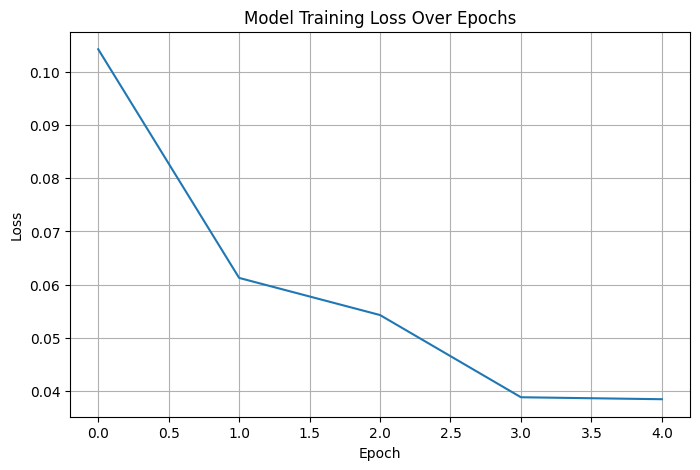

✅ Epoch-Loss graph displayed.


In [ ]:
import matplotlib.pyplot as plt

# Plot Epoch-Loss Graph
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.title('Model Training Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.show()

print("Epoch-Loss graph displayed.")

In [ ]:
import random

#evaluate performance
def evaluate_triplet_performance(encoder_model, image_dictionary, valid_categories, num_samples=100):
    correct_triplets = 0
    total_triplets = 0

    for _ in range(num_samples):

        pos_class = random.choice(valid_categories)

        if len(image_dictionary[pos_class]) < 2: continue

        a_path, p_path = random.sample(image_dictionary[pos_class], 2)

        neg_class = random.choice([c for c in valid_categories if c != pos_class])
        n_path = random.choice(image_dictionary[neg_class])

        try:
            def load_and_preprocess(path):
                img = tf.io.read_file(path)
                img = tf.io.decode_jpeg(img, channels=3)
                img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
                img = img / 255.0
                return np.expand_dims(img, axis=0) # Add batch dimension

            a_img = load_and_preprocess(a_path)
            p_img = load_and_preprocess(p_path)
            n_img = load_and_preprocess(n_path)

            a_embed = encoder_model.predict(a_img, verbose=0)
            p_embed = encoder_model.predict(p_img, verbose=0)
            n_embed = encoder_model.predict(n_img, verbose=0)

            pos_dist = np.sum(np.square(a_embed - p_embed))
            neg_dist = np.sum(np.square(a_embed - n_embed))

            if pos_dist < neg_dist:
                correct_triplets += 1
            total_triplets += 1
        except Exception as e:

            continue

    if total_triplets == 0: return 0.0
    return (correct_triplets / total_triplets) * 100

# Evaluate the model
performance_percentage = evaluate_triplet_performance(encoder, image_dict, valid_classes, num_samples=200)
print(f"✅ Triplet Performance (Anchor-Positive Dist < Anchor-Negative Dist): {performance_percentage:.2f}%")

✅ Triplet Performance (Anchor-Positive Dist < Anchor-Negative Dist): 97.00%


In [ ]:
import time
#database indexing

print("Starting FULL Database Indexing...")
start_time = time.time()

db_embeddings = []
db_paths = []
db_labels = []

total_count = 0

for category in valid_classes:
    print(f"Processing category: {category}...")


    img_list = image_dict[category]

    for img_path in img_list:
        try:

            img = tf.io.read_file(img_path)
            img = tf.io.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0

            # 2. Add Batch Dimension
            img = np.expand_dims(img, axis=0)

            # 3. Predict Embedding
            embed = encoder.predict(img, verbose=0)

            # 4. Save
            db_embeddings.append(embed[0])
            db_paths.append(img_path)
            db_labels.append(category)

            total_count += 1
            if total_count % 500 == 0:
                print(f"  -> Indexed {total_count} images so far...")

        except Exception as e:
            print(f"  ⚠️ Skipped bad file: {img_path}")


db_embeddings = np.array(db_embeddings)
end_time = time.time()

print("="*40)
print(f"✅ FULL INDEXING COMPLETE!")
print(f"Total Images in Database: {len(db_embeddings)}")
print(f"Time Taken: {round(end_time - start_time, 2)} seconds")
print(f"Database Shape: {db_embeddings.shape}")
print("="*40)

Starting FULL Database Indexing...
Processing category: shoes...
Processing category: skirt...
Processing category: dress...
  -> Indexed 500 images so far...
Processing category: outwear...
Processing category: hat...
Processing category: pants...
  -> Indexed 1000 images so far...
Processing category: t-shirt...
  -> Indexed 1500 images so far...
  -> Indexed 2000 images so far...
Processing category: longsleeve...
  -> Indexed 2500 images so far...
Processing category: shirt...
Processing category: shorts...
  -> Indexed 3000 images so far...
✅ FULL INDEXING COMPLETE!
Total Images in Database: 3068
Time Taken: 415.37 seconds
Database Shape: (3068, 128)


In [ ]:
!pip install pyngrok flask

In [ ]:
from flask import Flask, request, render_template
from google.colab.output import eval_js
from PIL import Image
import io
import base64
import os
import numpy as np
import random

app = Flask(__name__)


def get_img_base64(path):
    """Reads an image from disk and converts it to a base64 string for HTML display."""
    try:
        if not os.path.exists(path): return ""
        img = Image.open(path)
        img.thumbnail((300, 300)) # Resize for speed/display
        buf = io.BytesIO()
        img.save(buf, format='JPEG', quality=85)
        return base64.b64encode(buf.getvalue()).decode('utf-8')
    except:
        return ""


@app.route('/', methods=['GET', 'POST'])
def home():
    results = None
    uploaded_image = None

    if request.method == 'POST':
        if 'file' not in request.files: return "No file"
        f = request.files['file']
        if f.filename == '': return "No file"


        img = Image.open(f).convert('RGB')


        buf = io.BytesIO()
        img.save(buf, format='JPEG')
        uploaded_image = base64.b64encode(buf.getvalue()).decode('utf-8')

        img_resized = img.resize((IMG_SIZE, IMG_SIZE))
        arr = np.array(img_resized) / 255.0
        arr = np.expand_dims(arr, axis=0)


        query_vector = encoder.predict(arr, verbose=0)


        similarities = np.dot(query_vector, db_embeddings.T).flatten()


        top_indices = similarities.argsort()[-4:][::-1]

        results = []
        for i in top_indices:
            # Add a mock price to simulate a real shop
            price = random.choice([49.99, 75.00, 120.50, 299.00, 34.50])

            results.append({
                'score': int(similarities[i] * 100), # Convert decimal to percentage
                'label': db_labels[i],
                'price': price,
                'img': get_img_base64(db_paths[i])
            })

    return render_template('app.html', results=results, uploaded_image=uploaded_image)

#HTML(UI DESIGN)-
os.makedirs('templates', exist_ok=True)
html_code = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>FashionLens </title>
    <link href="https://fonts.googleapis.com/css2?family=Inter:wght@300;400;600&display=swap" rel="stylesheet">
    <style>
        :root { --primary: #111; --bg: #FAFAFA; --card-bg: #FFFFFF; }
        body {
            font-family: 'Inter', sans-serif; background-color: var(--bg); color: var(--primary);
            margin: 0; padding: 0; display: flex; flex-direction: column; align-items: center; min-height: 100vh;
        }
        header { width: 100%; padding: 20px 0; text-align: center; background: white; box-shadow: 0 1px 0 rgba(0,0,0,0.05); margin-bottom: 40px; }
        h1 { margin: 0; font-weight: 600; font-size: 1.2rem; letter-spacing: -0.5px; text-transform: uppercase; }

        .container { width: 90%; max-width: 1000px; display: grid; grid-template-columns: 1fr; gap: 40px; }

        /* UPLOAD SECTION */
        .upload-section { background: white; border-radius: 20px; padding: 40px; text-align: center; box-shadow: 0 20px 40px rgba(0,0,0,0.03); }
        .upload-box { border: 2px dashed #ddd; border-radius: 12px; padding: 40px 20px; cursor: pointer; transition: 0.3s; position: relative; }
        .upload-box:hover { border-color: #333; background: #f9f9f9; }
        input[type="file"] { position: absolute; width: 100%; height: 100%; top: 0; left: 0; opacity: 0; cursor: pointer; }

        .btn-scan { background: var(--primary); color: white; border: none; padding: 15px 40px; border-radius: 30px; font-size: 1rem; font-weight: 500; margin-top: 20px; cursor: pointer; width: 100%; max-width: 300px; }
        .preview-img { width: 150px; height: 150px; object-fit: cover; border-radius: 12px; box-shadow: 0 5px 15px rgba(0,0,0,0.1); margin-bottom: 15px; }

        /* RESULTS SECTION */
        .results-header { display: flex; justify-content: space-between; align-items: center; margin-bottom: 20px; }
        .results-title { font-size: 1.1rem; font-weight: 600; }
        .results-count { color: #888; font-size: 0.9rem; }

        .grid { display: grid; grid-template-columns: repeat(auto-fill, minmax(200px, 1fr)); gap: 20px; }
        .card { background: white; border-radius: 16px; overflow: hidden; box-shadow: 0 4px 20px rgba(0,0,0,0.04); transition: 0.3s; display: flex; flex-direction: column; }
        .card:hover { transform: translateY(-5px); box-shadow: 0 10px 30px rgba(0,0,0,0.08); }
        .card-img-container { width: 100%; height: 250px; background: #f4f4f4; display: flex; align-items: center; justify-content: center; overflow: hidden; }
        .card img { width: 100%; height: 100%; object-fit: cover; }
        .card-body { padding: 15px; }
        .product-name { font-size: 0.9rem; font-weight: 600; margin-bottom: 5px; text-transform: capitalize; }
        .product-price { font-size: 0.9rem; color: #555; margin-bottom: 10px; }
        .match-badge { display: inline-block; background: #f0f0f0; color: #333; padding: 4px 8px; border-radius: 6px; font-size: 0.75rem; font-weight: 600; }

        @media (min-width: 800px) {
            .container { grid-template-columns: 350px 1fr; align-items: start; }
            .upload-section { position: sticky; top: 40px; }
        }
    </style>
</head>
<body>
    <header><h1>Fashion Lens </h1></header>
    <div class="container">

        <div class="upload-section">
            {% if uploaded_image %}
                <p style="margin-bottom:10px; font-weight:500; color:#555;">Your Scan</p>
                <img src="data:image/jpeg;base64,{{ uploaded_image }}" class="preview-img">
                <form method="post" enctype="multipart/form-data">
                     <button onclick="window.location.href='/'" type="button" class="btn-scan" style="background:#fff; color:#333; border:1px solid #ddd;">Reset / New Scan</button>
                </form>
            {% else %}
                <h2 style="font-size:1.2rem; margin-bottom:20px;">Product Scan</h2>
                <form method="post" enctype="multipart/form-data" id="scanForm">
                    <div class="upload-box">
                        <input type="file" name="file" onchange="document.getElementById('scanForm').submit()">
                        <div style="font-size:3rem; margin-bottom:10px;">📸</div>
                        <p style="color:#888; margin:0;">Tap to Upload Image</p>
                    </div>
                </form>
            {% endif %}
        </div>

        <div class="results-section">
            {% if results %}
                <div class="results-header">
                    <span class="results-title">Similar Items Found</span>
                    <span class="results-count">{{ results|length }} Products</span>
                </div>
                <div class="grid">
                    {% for item in results %}
                    <div class="card">
                        <div class="card-img-container">
                            <img src="data:image/jpeg;base64,{{ item.img }}">
                        </div>
                        <div class="card-body">
                            <div class="product-name">{{ item.label }}</div>
                            <div class="product-price">${{ item.price }}</div>
                            <div class="match-badge">{{ item.score }}% Match</div>
                        </div>
                    </div>
                    {% endfor %}
                </div>
            {% else %}
                <div style="text-align:center; padding: 80px 0; color:#aaa;">
                    <p>Upload an image to see results here.</p>
                </div>
            {% endif %}
        </div>
    </div>
</body>
</html>
"""

with open('templates/app.html', 'w') as f:
    f.write(html_code)


print("="*60)
print("🚀 FASHION LENS IS READY!")
print("Click the link below to open your app:")
print(eval_js("google.colab.kernel.proxyPort(5000)"))
print("="*60)

app.run(host='0.0.0.0', port=5000)

🚀 FASHION LENS IS READY!
Click the link below to open your app:
https://5000-m-s-1tqfpmrdy8olp-a.asia-southeast1-1.prod.colab.dev
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [05/Jan/2026 13:56:31] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Jan/2026 13:56:48] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Jan/2026 13:56:52] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Jan/2026 13:57:10] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Jan/2026 13:57:20] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Jan/2026 13:57:23] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Jan/2026 13:57:27] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Jan/2026 13:57:31] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Jan/2026 13:57:50] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Jan/2026 13:57:56]